

>Do obserwacji z zadania 1 odsyłam do Zadania2, w aktualnym zadaniu w sumie za wiele sie z neigo nie przyda, tworzymy model ktory ma poprostu odczytywac liczby, nie potrzebujemy dataframe'u z 1 dwóch zadań



In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset,random_split
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix
import os
import random
import time

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



full_train=datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
train_size = int(0.9 * len(full_train))

val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cpu


In [20]:
print(len(train_dataset))
print("Wielkości zbioru testowego:",len(test_dataset))
print(len(val_dataset))

54000
Wielkości zbioru testowego: 10000
6000


In [21]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

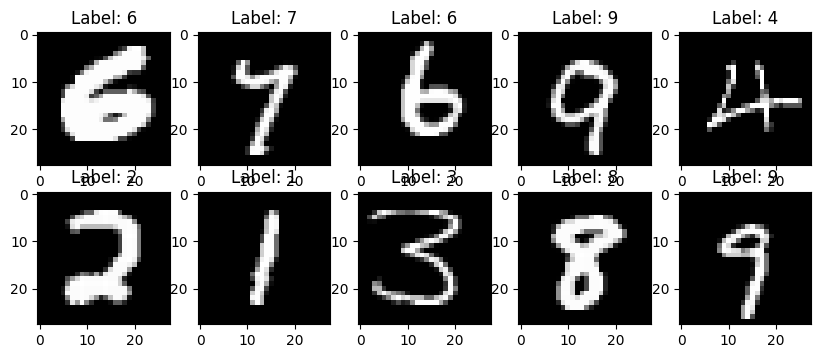

In [22]:
#Przykladowe obrazy ze zbioru
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    image, label = train_dataset[i]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.rlu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



model = SimpleNN()


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
for epoch in range(3):
  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
  print(f'Epoch {epoch+1}, Loss: {loss.item()}')
  print(f'Czas treningu:{time.time():.2f}s')

Epoch 1, Loss: 0.2180008739233017
Czas treningu:1756030318.21s
Epoch 2, Loss: 0.07166601717472076
Czas treningu:1756030327.43s
Epoch 3, Loss: 0.12796615064144135
Czas treningu:1756030336.47s


In [26]:
val_correct=0
val_total=0
with torch.no_grad():
  for images, labels in val_loader:
    outputs=model(images)
    _, predicted=torch.max(outputs.data,1)
    val_total+=labels.size(0)
    val_correct+=(predicted==labels).sum().item()



test_correct=0
test_total=0
with torch.no_grad():
  for images, labels in test_loader:
    outputs=model(images)
    _, predicted=torch.max(outputs.data,1)
    test_total+=labels.size(0)
    test_correct+=(predicted==labels).sum().item()
print(f"Accurancy for test:{100*test_correct/test_total:.2f}%")
print(f"Accurancy for validation:{100*val_correct/val_total:.2f}%")

Accurancy for test:96.54%
Accurancy for validation:96.02%


#Wnioski z 1 testowego modelu:

Model osiągął nie najgorsze wyniki, zobaczymy jak dalej poradzi sobie CNN

#Czym jest CNN
Konwolucyjna sieć neuronowa: to sieć neuronowa która jest często używana do rozpoznawania pbrazów, od klasycznej jest lepsza w wyłapywaniu szczegołów   
#Charakterystyka:
Główne typy warstw

Convolutional (Conv2D):

Filtry przesuwają się po obrazie i wyciągają cechy (np. krawędzie, tekstury).

Parametr: liczba filtrów (np. 32, 64), rozmiar filtra (3x3, 5x5).

Batch Normalization (BatchNorm):

Normalizuje wyjście warstwy w batchu (średnia ~0, odchylenie std ~1).

Stabilizuje i przyspiesza uczenie.

Activation (ReLU):

Wprowadza nieliniowość: zamienia wartości ujemne na 0.

Pooling (MaxPool / AvgPool):

Redukuje wymiary map cech, wybierając np. maksymalną wartość w oknie.

Zmniejsza pamięć i zwiększa odporność na przesunięcia.

Dropout:

Losowo wyłącza część neuronów w czasie treningu, zapobiegając overfittingowi.

Fully Connected (FC / Linear):

Każdy neuron połączony ze wszystkimi wejściami.

Służy do łączenia wyciągniętych cech i klasyfikacji.

In [95]:
#Prosty CNN z nontatnika pozdrawiam wspaniałych prowadzących:))))))
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model2 = SimpleCNN()

In [96]:
from torch.optim import Adam

EPOCHS = 5
lr = 1e-3
optimizer = Adam(model2.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

from sklearn.metrics import precision_score, recall_score, f1_score

def run_epoch(loader, train: bool):
    model2.train(train)
    epoch_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            logits = model2(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)

        correct += (preds == yb).sum().item()
        total += yb.size(0)


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return epoch_loss / total, correct / total, precision, recall, f1
history = {k: [] for k in ["train_loss", "train_acc", "val_loss", "val_acc", "train_precision", "train_recall", "train_f1", "val_precision", "val_recall", "val_f1"]}

start = time.time()
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_precision, tr_recall, tr_f1 = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_precision, va_recall, va_f1 = run_epoch(val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["train_precision"].append(tr_precision)
    history["train_recall"].append(tr_recall)
    history["train_f1"].append(tr_f1)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    history["val_precision"].append(va_precision)
    history["val_recall"].append(va_recall)
    history["val_f1"].append(va_f1)


    print(f"Ep {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")

print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.2370 acc 0.9256 | val loss 0.0883 acc 0.9755
Ep 02/5 | train loss 0.0785 acc 0.9755 | val loss 0.0526 acc 0.9842
Ep 03/5 | train loss 0.0573 acc 0.9829 | val loss 0.0472 acc 0.9865
Ep 04/5 | train loss 0.0488 acc 0.9848 | val loss 0.0411 acc 0.9893
Ep 05/5 | train loss 0.0394 acc 0.9877 | val loss 0.0429 acc 0.9882
Czas treningu: 378.6s


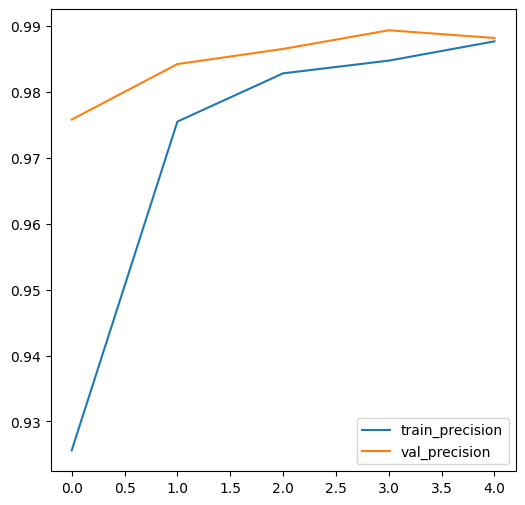

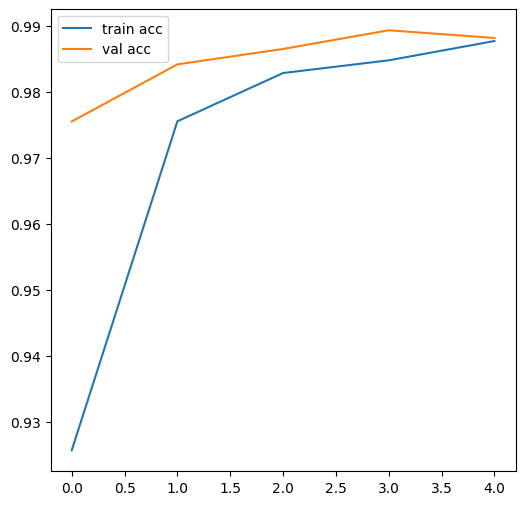

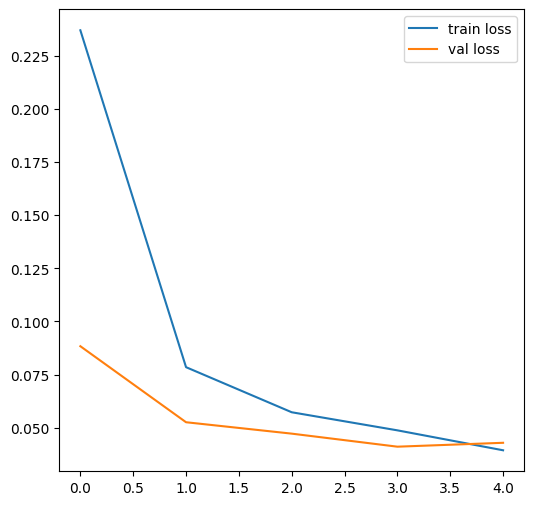

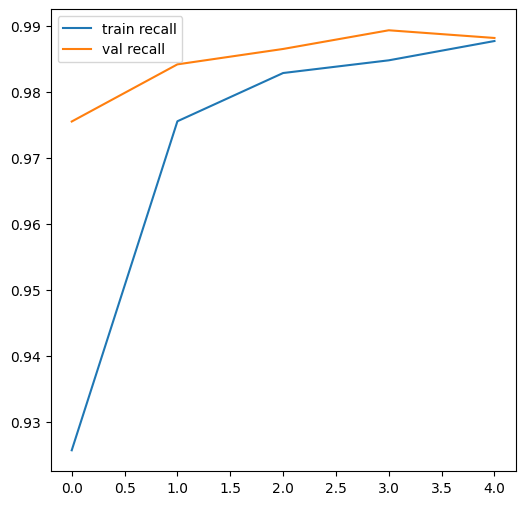

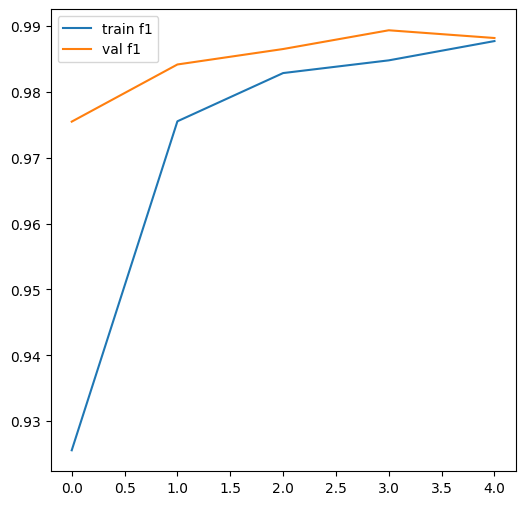

In [100]:
plt.figure(figsize=(6,6))
plt.plot(history["train_precision"], label="train_precision")
plt.plot(history["val_precision"], label="val_precision")
plt.legend()
plt.show()
plt.figure(figsize=(6,6))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.legend()
plt.show()
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.legend()
plt.show()
plt.figure(figsize=(6,6))
plt.plot(history["train_recall"], label="train recall")
plt.plot(history["val_recall"], label="val recall")
plt.legend()
plt.show()
plt.figure(figsize=(6,6))
plt.plot(history["train_f1"], label="train f1")
plt.plot(history["val_f1"], label="val f1")
plt.legend()
plt.show()

#Wnioski z wykresów:
Jak widać z wykresow doszło do ciekawego zdarzenia, wykresy dla accuracy,recall, f1 i precision są identyczne, co jest pozytywnym zjawiskiem, oznacza to, ze model ma zbalansowane klasy oraz to, że model praktycznie nie myli klas, dlatego w kolejnym CNNie, który będzie lepszą wersją tego, użyję juz tylko accuracy i lossów jako swoich metryk

Test accuracy: 0.9906


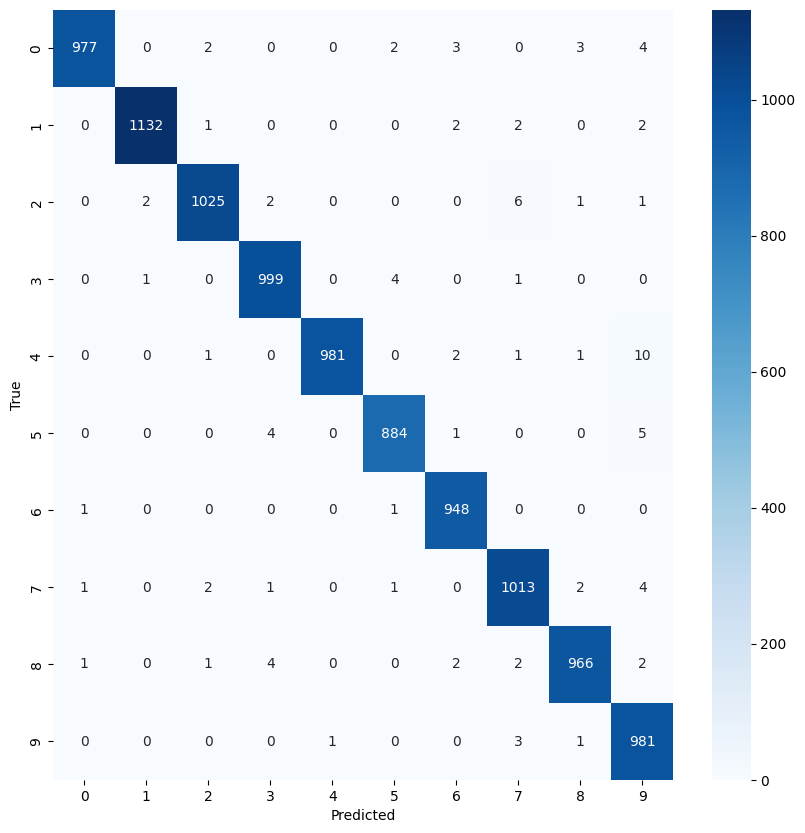

In [51]:
model2.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model2(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_pred,y_true)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Wnioski z SimpleCNN:
Accuracy przekroczyło juz 99% co jest dobrym znakiem i pokazuje supremacy CNN, nad zwykłymi sieciami neuronowymi w termsach obrazów

#CNN 2.0
Ponizej znajduje się mój model  sieci w ktorym zastosowałem BatchNorm, zwiekszylem ilość warstw i zmniejszylem dropouty

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UltimateCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()


        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2=nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3=nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout(0.25)
        self.dropout_fc=nn.Dropout(0.4)


        dummy_input = torch.randn(1, 1, 28, 28)
        x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        self.fc1_input_features = x.view(x.size(0), -1).size(1)

        self.fc1 = nn.Linear(self.fc1_input_features, 256)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout_conv(x)

        x = self.conv2(x)
        x=self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout_conv(x)

        x = self.conv3(x)
        x=self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout_conv(x)


        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model3=UltimateCNN

In [89]:
from torch.optim import Adam

EPOCHS = 5
lr = 1e-3
model3 = UltimateCNN()
optimizer = Adam(model3.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):

    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model3.train()
    else:
        model3.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model3(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.2185 acc 0.9310 | val loss 0.0521 acc 0.9832
Ep 02/5 | train loss 0.0832 acc 0.9749 | val loss 0.0419 acc 0.9875
Ep 03/5 | train loss 0.0672 acc 0.9799 | val loss 0.0351 acc 0.9905
Ep 04/5 | train loss 0.0573 acc 0.9822 | val loss 0.0359 acc 0.9900
Ep 05/5 | train loss 0.0496 acc 0.9846 | val loss 0.0357 acc 0.9897
Czas treningu: 653.7s


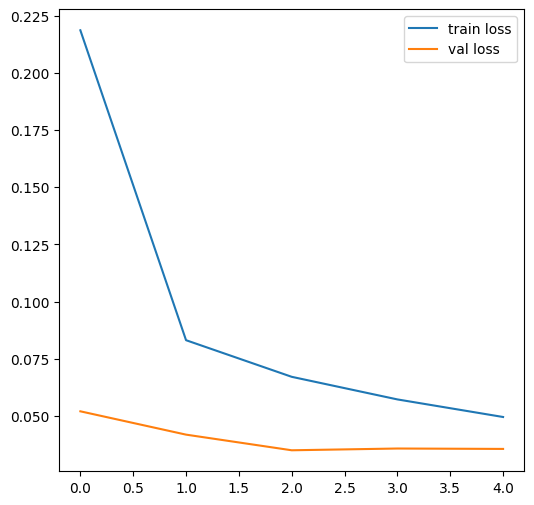

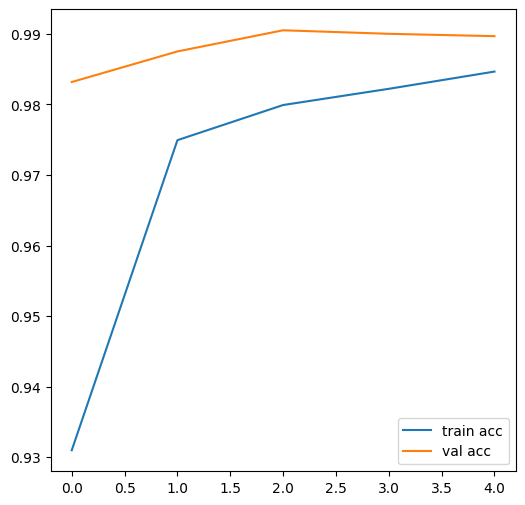

In [90]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.legend()
plt.show()
plt.figure(figsize=(6,6))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.legend()
plt.show()

Test accuracy: 0.9929


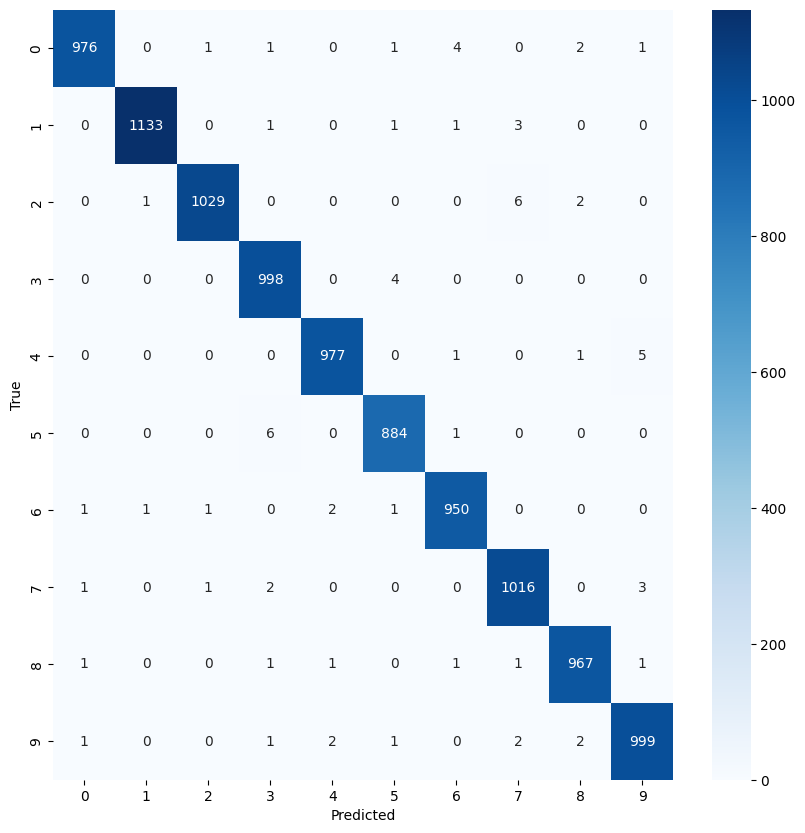

In [94]:
model3.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model3(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_pred,y_true)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




#Wnioski końcowe(Ultimate CNN):
Jak coś piszę to jako pierwsze wnioski haha, więc zacznijmy od mojego ultimate CNN'a jak widać użyłem, aż 3 warstw batchnorm, trochę to oczywiście spowolnilo proces całego treningu lecz dało korzystniejsze rezulaty, aktualny wynik jest 0 0.07% od wyniku gdy używałem tylko 1 batchnormu, teraz zmniejszylem jeszcze dropuout_fc i wyniki są zatrważająco dobre 99,29%, gdzie jeszcze wczoraj na podobnym configu, tylko wlaśnie ze zwiększonym dropoutem_fc osiągłem 99,14%, to juz pokazuje jak odpowiednio zarządzac parametrami.
#Dlaczego dropout jest tak kluczowy:
Dropout to warstwa losowa, dla np. Dropout(0.6) oznacza top, ze średnio 60% neuronów jest wyłączone, ma to sprawić by sieć nie polegala na pojedynczych neuronach lecz na całej zawartości sieci, więc mały dropout:

-sieć sobie poradzi,ale może zostac przeuczona, za duży dropout:

-sieć zacznie odczuwac problemy mniejszej ilości neuronow zmniejszy się dokładnosc

Dlaczego więc zmieniajac dropout o 20% dostaliśmy tak duzo różnice bo aż o 0,15% w accuracy, glównym powodem może byc to, ze mamy już 3 warstwy BatchNormu ktore działaja nam stabilizująco oraz regulują wartości, więc dropując 60% neuronów zamiast zadziałac pozytywnie, uprzykszyl tylko pracę całej sieci.

#Końcowe wyniki
Wiec zapraszam ponownie do obejrzenia macierzy korelacji dla UltimateCNN, widac tam bardzo ładnie ile liczb zostalo rozpoznanych, fajnie widać też różnice względem wcześniejszego CNN'a
#Moja osobista uwaga do sprawdzajacych  
Wybaczcie, ze nie bawiłem się jakoś bardzo szerkością sieci czy , caly tydzień mialem zapierdol, i w sumie porządnie zabralem się dopiero za to wczoraj(sobotę), i tak jestem dumny z wyniku Accurancy ultimate CNN XDDDDD
#A i jeszcze jedno:
Widze, małe odchylenia na wykresach dla val zarowno accuracy i loss, spytalem czata, mówi , że takie drobne fluktuacje są normalne i nie ma się czym martwić